# Walmart Store Sales Forecasting - Multivariate Time Series

## Importing all the required packages

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from pandas.plotting import lag_plot
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.stattools import grangercausalitytests
from pmdarima import auto_arima
from timeit import default_timer as timer
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller

In [2]:
warnings.filterwarnings('ignore')

## Multivariate EDA

In [5]:
#This file is obtained from the unvariate time series notebook
data = pd.read_csv('clean_data.csv')
data.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
data.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,week,month,year
0,1,1,2/5/10,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2,2010
1,1,2,2/5/10,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2,2010
2,1,3,2/5/10,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2,2010
3,1,4,2/5/10,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2,2010
4,1,5,2/5/10,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2,2010


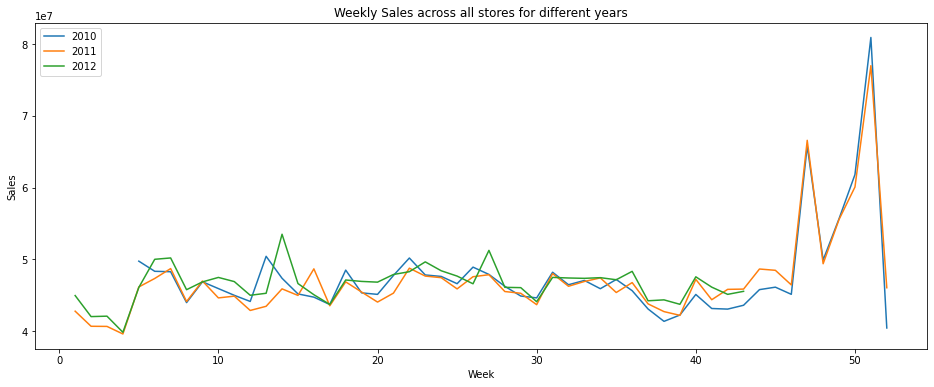

In [5]:
plt.figure(figsize=(16,6))
weekly_data = data.groupby(['year','week'])[['Weekly_Sales']].sum().reset_index()
plt.plot(weekly_data[weekly_data.year == 2010]['week'], weekly_data[weekly_data.year == 2010]['Weekly_Sales'], label = 2010)
plt.plot(weekly_data[weekly_data.year == 2011]['week'], weekly_data[weekly_data.year == 2011]['Weekly_Sales'], label = 2011)
plt.plot(weekly_data[weekly_data.year == 2012]['week'], weekly_data[weekly_data.year == 2012]['Weekly_Sales'], label = 2012)
plt.legend()
plt.title("Weekly Sales across all stores for different years")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.show()


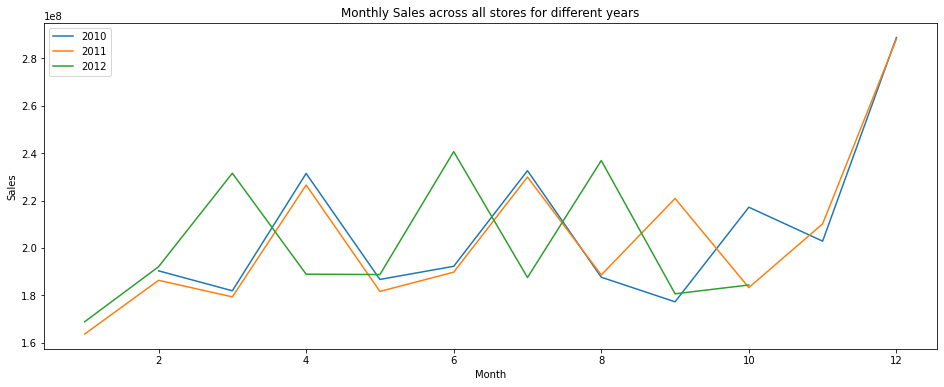

In [6]:
#Patterns are missing in monthly data
plt.figure(figsize=(16,6))
month_data = data.groupby(['year','month'])[['Weekly_Sales']].sum().reset_index()
plt.plot(month_data[month_data.year == 2010]['month'], month_data[month_data.year == 2010]['Weekly_Sales'], label = 2010)
plt.plot(month_data[month_data.year == 2011]['month'], month_data[month_data.year == 2011]['Weekly_Sales'], label = 2011)
plt.plot(month_data[month_data.year == 2012]['month'], month_data[month_data.year == 2012]['Weekly_Sales'], label = 2012)
plt.legend()
plt.title("Monthly Sales across all stores for different years")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.show()

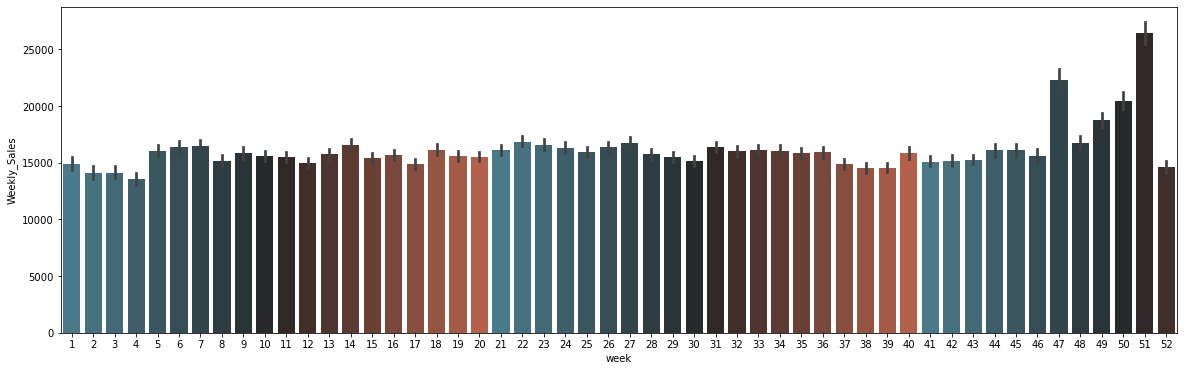

In [7]:
plt.figure(figsize=(20,6))
fig = sns.barplot(x='week', y='Weekly_Sales', data=data, palette=sns.diverging_palette(220, 20, n=20, center = "dark")) 


## Heat Map for all columns

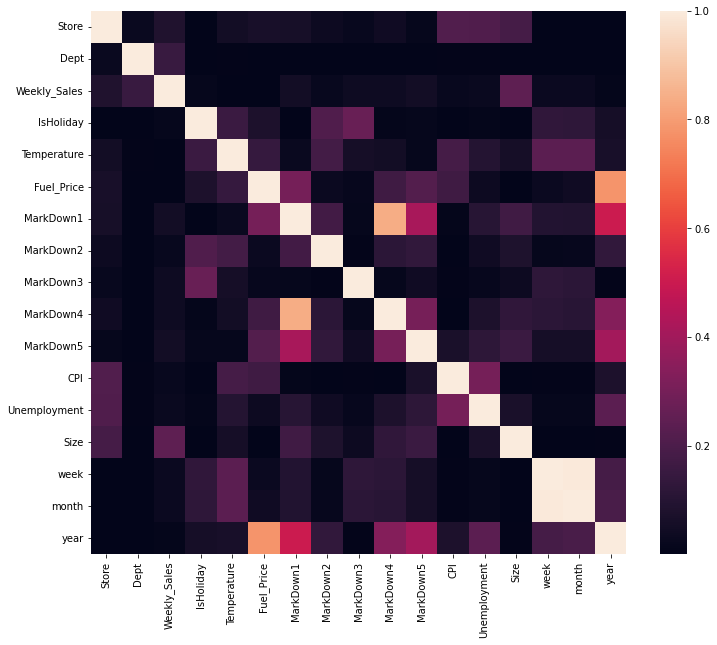

In [8]:
plt.figure(figsize = (12,10))
sns.heatmap(data.corr().abs())    # To see the correlations without dropping columns
plt.show()

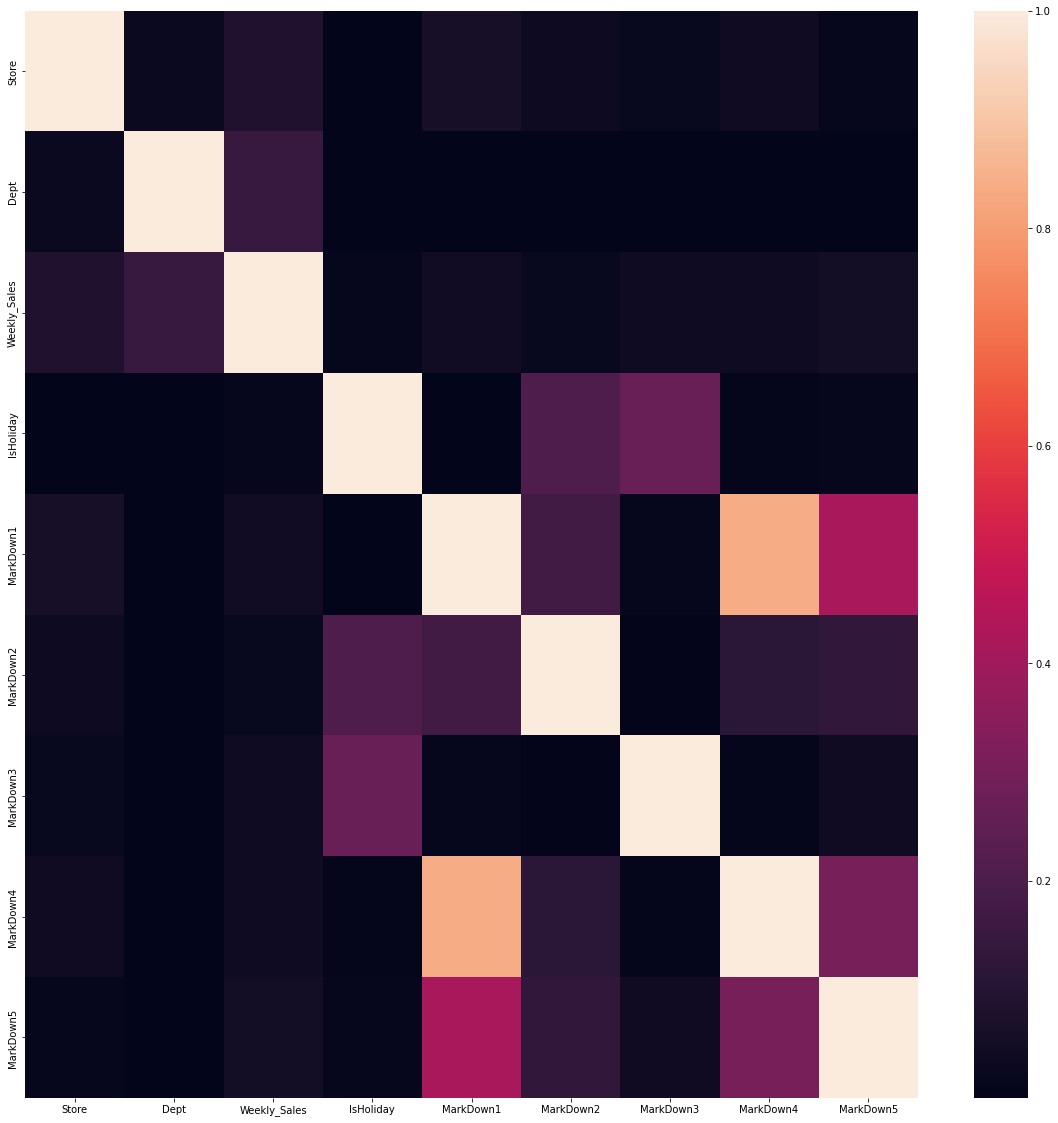

In [9]:
## Heat map with required columns only
data = data[['Store','Dept','Date','Weekly_Sales','IsHoliday','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']]
plt.figure(figsize = (20,20))
sns.heatmap(data.corr().abs())    # To see the correlations without dropping columns
plt.show()

### Markdown 1 is highly correlated with 4 and 5, hence combining these 3 variables to one variable to remove the multicollinearity issue

In [10]:
data['MarkDown_145'] = data['MarkDown1'] + data['MarkDown4'] + data['MarkDown5']
data.drop(['MarkDown1','MarkDown4','MarkDown5'],axis=1,inplace=True)
data.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,MarkDown2,MarkDown3,MarkDown_145
0,1,1,2/5/10,24924.50,False,0.0,0.0,0.0
1,1,2,2/5/10,50605.27,False,0.0,0.0,0.0
2,1,3,2/5/10,13740.12,False,0.0,0.0,0.0
3,1,4,2/5/10,39954.04,False,0.0,0.0,0.0
4,1,5,2/5/10,32229.38,False,0.0,0.0,0.0


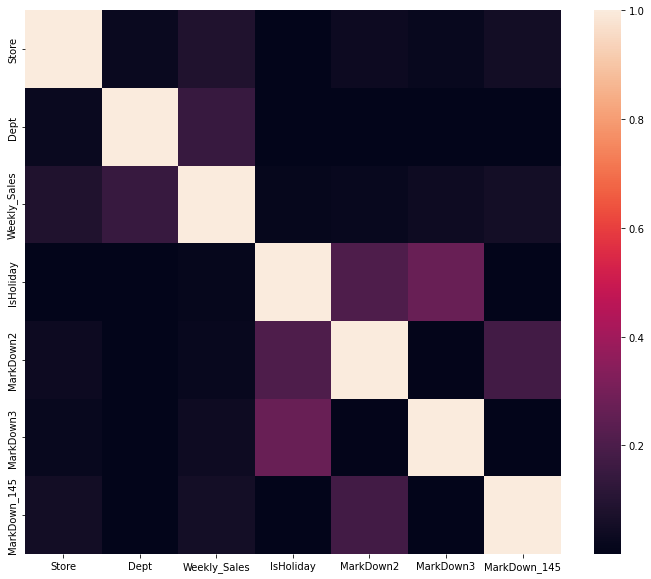

In [11]:
plt.figure(figsize = (12,10))
sns.heatmap(data.corr().abs())    # To see the correlations without dropping columns
plt.show()

### Checking if IsHoliday column has any effect with respect to Markdowns

In [12]:
data["IsHoliday"] = data["IsHoliday"].astype(int)

<AxesSubplot:xlabel='IsHoliday', ylabel='MarkDown_145'>

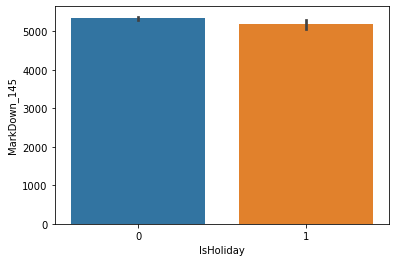

In [13]:
sns.barplot(x='IsHoliday', y='MarkDown_145', data=data)

<AxesSubplot:xlabel='IsHoliday', ylabel='MarkDown2'>

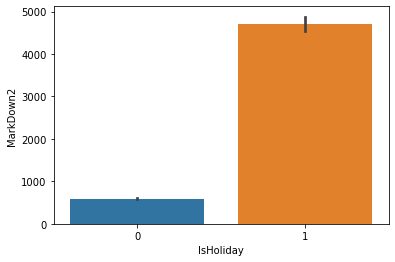

In [14]:
sns.barplot(x='IsHoliday', y='MarkDown2', data=data)

<AxesSubplot:xlabel='IsHoliday', ylabel='MarkDown3'>

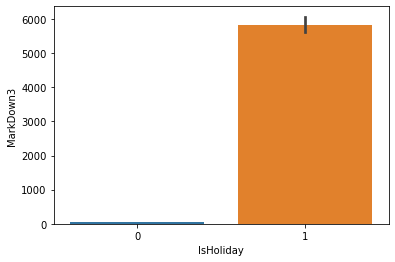

In [15]:
sns.barplot(x='IsHoliday', y='MarkDown3', data=data)

### Keeping all the variables because IsHoliday has slight correlation between markdown 2 and 3 but not on markdown145 - hence dropping the IsHoliday column
### Markdown 145 is important to model the effect on non-holiday seasons as well 
### Need to check if all the above variables are stationary or not


In [16]:
data.drop('IsHoliday',axis=1,inplace=True)

In [17]:
data['Date'] = pd.to_datetime(data['Date'])

In [18]:
data_top3stores = data[data.Store.isin([20,4,14]) ].groupby(['Store','Date'])['Weekly_Sales','MarkDown2','MarkDown3'].sum().reset_index()
data_top3stores.set_index('Date',inplace=True)
data_top3stores.head()



store20 = data_top3stores[data_top3stores.Store == 20]
store4 = data_top3stores[data_top3stores.Store == 4]
store14 = data_top3stores[data_top3stores.Store == 14]
ini = int(len(store20)*0.75)
store20.shape,store4.shape,store14.shape


((143, 4), (143, 4), (143, 4))

In [19]:
ini

107

In [20]:
store20.head()

,Store,Weekly_Sales,MarkDown2,MarkDown3
Date,,,,
2010-02-05,20,2401395.47,0.0,0.0
2010-02-12,20,2109107.90,0.0,0.0
2010-02-19,20,2161549.76,0.0,0.0
2010-02-26,20,1898193.95,0.0,0.0
2010-03-05,20,2119213.72,0.0,0.0


In [21]:
df_train20, df_test20 = store20[0:ini], store20[-(len(store20)-ini):]
df_train4, df_test4 = store4[0:ini], store4[-(len(store4)-ini):]
df_train14, df_test14 = store14[0:ini], store14[-(len(store14)-ini):]
df_train20.shape, df_test20.shape

((107, 4), (36, 4))

In [22]:
# Augmented Dickey-Fuller Test (ADF Test)
def adf_test(time_series, signif=0.05):
    testing = adfuller(time_series, autolag='AIC')
    adf = pd.Series(testing[0:4], index=['Test Statistic','p-value','Number of Lags','Number of Observations'])
    for key,value in testing[4].items():
        adf['Critical Value (%s)'%key] = value
    print (adf)
    p = adf['p-value']
    if p <= signif:
        print(f" Series is Stationary")
    else:
        print(f" Series is Non-Stationary")


### After trying all the methods to stationarize Markdown_145 - shifting, differencing, Markdown_145 is not stationary - dropping the column

In [23]:
#df_train20['MarkDown4_new'] = df_train20.MarkDown_145.rolling(5, min_periods=1).mean() #- did not work - SMA
#df_train['MarkDown4_new'] = df_train.MarkDown4.expanding().mean() #CMA
#df_train20['MarkDown4_new'] = df_train20.MarkDown_145.ewm(alpha=0.05, adjust=False).mean()  #EMA
# df_train20['MarkDown4_new'] = df_train20['MarkDown_145'].diff() #differencing
# adf_test(df_train20["MarkDown_145"])
# data_top3stores.drop('MarkDown_145',axis=1,inplace=True)

### From the above results Markdown_145 cannot be stationarized using any methods - SMA, EMA, CMA or differencing. 
### Therefore, Dropping Markdown_145 column

In [24]:
#data_top3stores.drop('MarkDown_145',axis=1,inplace=True)
#data_top3stores.drop('Date',axis=1,inplace=True)

store20 = data_top3stores[data_top3stores.Store == 20].drop('Store',axis=1)
store4 = data_top3stores[data_top3stores.Store == 4].drop('Store',axis=1)
store14 = data_top3stores[data_top3stores.Store == 14].drop('Store',axis=1)

df_train20, df_test20 = store20[0:ini], store20[-(len(store20)-ini):]
df_train4, df_test4 = store4[0:ini], store4[-(len(store4)-ini):]
df_train14, df_test14 = store14[0:ini], store14[-(len(store14)-ini):]
df_train20.shape, df_test20.shape

((107, 3), (36, 3))

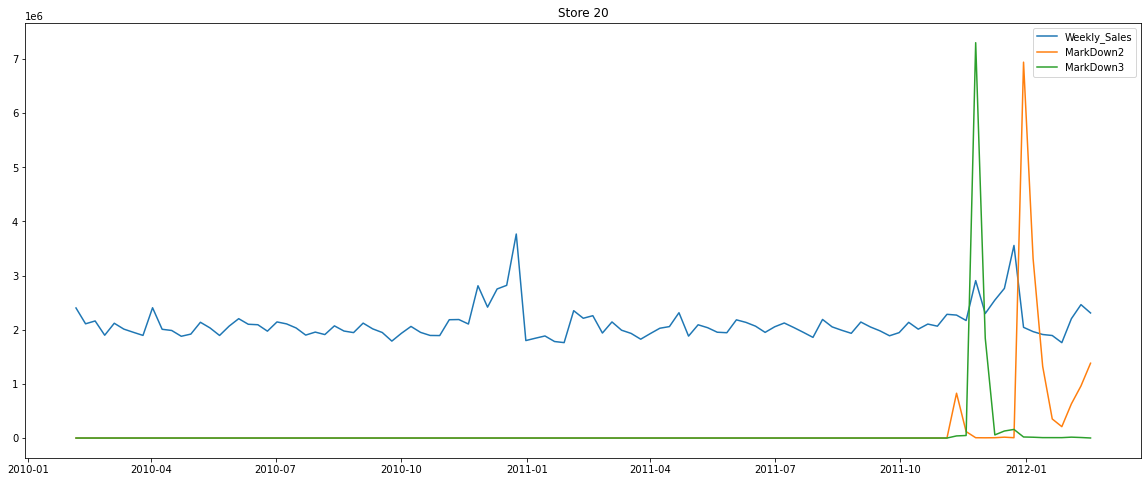

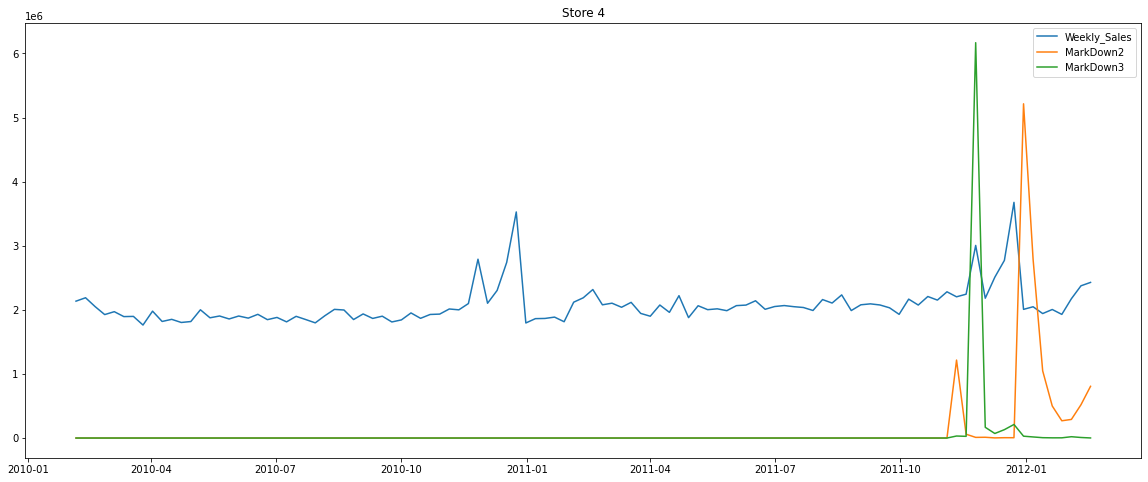

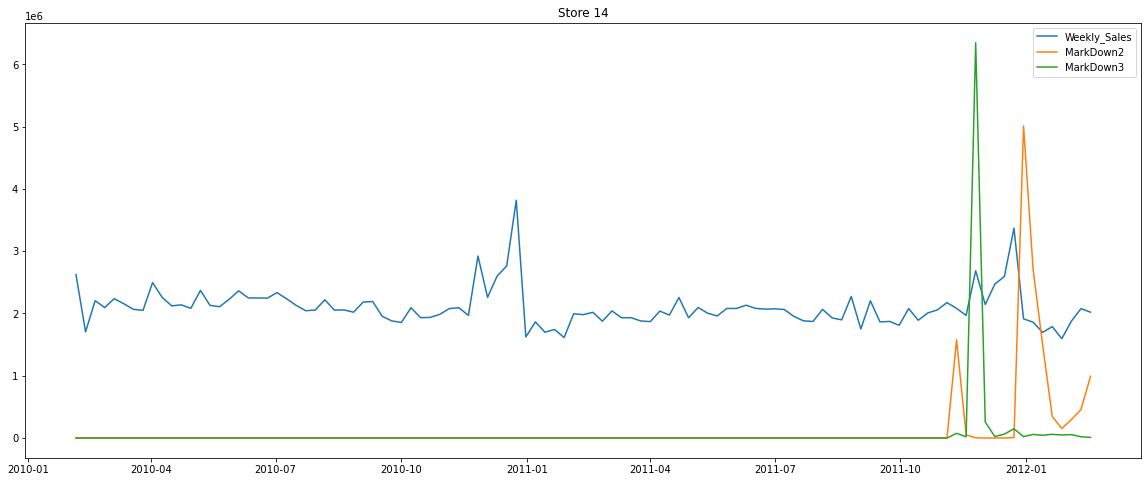

In [25]:
def all_plot(df_train20,label):
    plt.figure(figsize = (20,8))
    plt.plot(df_train20.index,df_train20['Weekly_Sales'],label = 'Weekly_Sales')
    plt.plot(df_train20.index,df_train20['MarkDown2'],label = 'MarkDown2')
    plt.plot(df_train20.index,df_train20['MarkDown3'],label = 'MarkDown3')
    plt.title(label)
    plt.legend()
    plt.show()

all_plot(df_train20,'Store 20')
all_plot(df_train4,'Store 4')
all_plot(df_train14,'Store 14')

In [26]:
#apply adf test on the series
def Dicky_Fuller_test(df_train20,label):
    print("                 ", label)
    adf_test(df_train20["Weekly_Sales"])
    adf_test(df_train20["MarkDown2"])
    adf_test(df_train20["MarkDown3"])

    print(" ")
    print(" ")

Dicky_Fuller_test(df_train20,'Store 20')
Dicky_Fuller_test(df_train4,'Store 4')

                  Store 20
Test Statistic             -4.719934
p-value                     0.000077
Number of Lags              4.000000
Number of Observations    102.000000
Critical Value (1%)        -3.496149
Critical Value (5%)        -2.890321
Critical Value (10%)       -2.582122
dtype: float64
 Series is Stationary
Test Statistic           -1.871161e+01
p-value                   2.034595e-30
Number of Lags            1.300000e+01
Number of Observations    9.300000e+01
Critical Value (1%)      -3.502705e+00
Critical Value (5%)      -2.893158e+00
Critical Value (10%)     -2.583637e+00
dtype: float64
 Series is Stationary
Test Statistic           -8.036739e+00
p-value                   1.893846e-12
Number of Lags            0.000000e+00
Number of Observations    1.060000e+02
Critical Value (1%)      -3.493602e+00
Critical Value (5%)      -2.889217e+00
Critical Value (10%)     -2.581533e+00
dtype: float64
 Series is Stationary
 
 
                  Store 4
Test Statistic             

## Granger Causality test

In [27]:
#apply this only if series is stationary
def granger_casuality_test(df_train20,label):
    try:
        print(label)
        temp = df_train20[["Weekly_Sales","MarkDown2"]].pct_change().dropna() #accept null hypotheses #markdown causing weekly sales
        #temp = df_train20[["Weekly_Sales","MarkDown3"]].pct_change().dropna() #accept null hypotheses
        temp.replace([np.inf, -np.inf], np.nan, inplace=True)
        temp.dropna(inplace=True)
        gc_res = grangercausalitytests(temp, [3])
        print(" ")
        
    except:
        print('  ')
        
        
granger_casuality_test(df_train20,'Store 20')
granger_casuality_test(df_train4,'Store 4')


Store 20

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.2810  , p=0.3946  , df_denom=4, df_num=3
ssr based chi2 test:   chi2=10.5680 , p=0.0143  , df=3
likelihood ratio test: chi2=7.4065  , p=0.0600  , df=3
parameter F test:         F=1.2810  , p=0.3946  , df_denom=4, df_num=3
 
Store 4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.0898  , p=0.2443  , df_denom=4, df_num=3
ssr based chi2 test:   chi2=17.2409 , p=0.0006  , df=3
likelihood ratio test: chi2=10.3716 , p=0.0157  , df=3
parameter F test:         F=2.0898  , p=0.2443  , df_denom=4, df_num=3
 


### No interaction between any of the markdown with sales from the above results. This is because p-value for SSR based F test is always greater than 0.05. Hence, we fail to reject the null hyptheses

# Vector Auto Regressive (VAR)

### Vector Auto Regressive modelling - grid search - choose the order with least AIC

### Store 20

In [28]:
#grid search for order P
for i in [1,2,3,4,5,6]: #trying till 6th order because we do not have too many observations
    model = VAR(df_train20)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print()

Order = 1
AIC:  78.76033668917295

Order = 2
AIC:  78.8802659705377

Order = 3
AIC:  79.00228568566372

Order = 4
AIC:  79.0146903304956

Order = 5
AIC:  75.9549533763985

Order = 6
AIC:  75.71156934177728



In [29]:
# model fitting -- least AIC order
model20 = VAR(df_train20)
results20 = model20.fit(maxlags=6, ic='aic')
results20.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     21:16:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    77.1874
Nobs:                     101.000    HQIC:                   76.3090
Log likelihood:          -4196.37    FPE:                7.70948e+32
AIC:                      75.7116    Det(Omega_mle):     4.59669e+32
--------------------------------------------------------------------
Results for equation Weekly_Sales
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const             1297114.832495    379482.178582            3.418           0.001
L1.Weekly_Sales         0.373755         0.117048            3.193           0.001
L1.MarkDown2           -0.155977         0.27

## Durbin-Watson statistic

In [30]:
from statsmodels.stats.stattools import durbin_watson

out = durbin_watson(results20.resid)

for col, val in zip(df_train20.columns, out):
    print(col, ':', round(val, 2))

Weekly_Sales : 1.97
MarkDown2 : 2.41
MarkDown3 : 1.85


As a rule of thumb, test statistic values between the range of 1.5 and 2.5 are considered normal. Therefore, there is neither correlation left in the residuals nor patterns in the time series left to be explained by the model

MAPE:  4.5


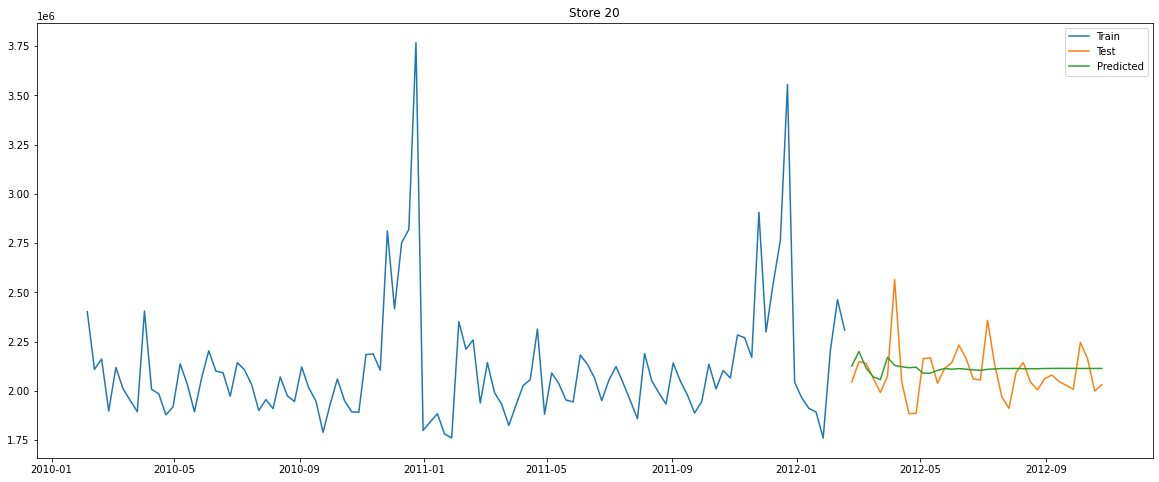

In [31]:
# forecasting function
def forecast(df_train20,df_test20,results20,label):
    try:
        lag_order = results20.k_ar
        predicted20 = results20.forecast(df_train20.values[-lag_order:],steps = len(df_test20))
        predicted20 = pd.DataFrame(data = predicted20, columns = ['Weekly_Sales','MarkDown2','MarkDown3'])
        df_test20.reset_index(drop=True,inplace=True)
        mape = np.round((abs(predicted20['Weekly_Sales'] - df_test20['Weekly_Sales'])/ df_test20['Weekly_Sales'] * 100).mean(), 1)
        
        print('MAPE: ', round(mape,2))
        idx = pd.date_range(start='2012-02-24', end='2012-10-26', freq='7D')
        predicted20['Date'] = idx
        df_test20['Date'] = idx
        df_train20['Date'] = df_train20.index

        plt.figure(figsize = (20,8))
        plt.plot(df_train20['Date'],df_train20['Weekly_Sales'],label = 'Train')
        plt.plot(df_test20['Date'],df_test20['Weekly_Sales'],label = 'Test')
        plt.plot(predicted20['Date'],predicted20['Weekly_Sales'],label = 'Predicted')
        plt.title(label)
        plt.legend()
        plt.show()
        df_test20.drop('Date',axis=1,inplace=True)
        df_train20.drop('Date',axis=1,inplace=True)
        predicted20.drop('Date',axis=1,inplace=True)
    
    except:
        lag_order = results20.k_ar
        predicted20 = results20.forecast(df_train20.values[-lag_order:],steps = len(df_test20))
        predicted20 = pd.DataFrame(data = predicted20, columns = ['Weekly_Sales','MarkDown2'])
        df_test20.reset_index(drop=True,inplace=True)
        mape = np.round((abs(predicted20['Weekly_Sales'] - df_test20['Weekly_Sales'])/ df_test20['Weekly_Sales'] * 100).mean(), 1)
        
        print('MAPE: ', round(mape,2))
        
        idx = pd.date_range(start='2012-02-24', end='2012-10-26', freq='7D')
        predicted20['Date'] = idx
        df_test20['Date'] = idx
        df_train20['Date'] = df_train20.index

        plt.figure(figsize = (20,8))
        plt.plot(df_train20['Date'],df_train20['Weekly_Sales'],label = 'Train')
        plt.plot(df_test20['Date'],df_test20['Weekly_Sales'],label = 'Test')
        plt.plot(predicted20['Date'],predicted20['Weekly_Sales'],label = 'Predicted')
        plt.title(label)
        plt.legend()
        plt.show()
        df_test20.drop('Date',axis=1,inplace=True)
        df_train20.drop('Date',axis=1,inplace=True)
        predicted20.drop('Date',axis=1,inplace=True)
            
    return 

forecast(df_train20,df_test20,results20,'Store 20')

## Store 4

In [32]:
#grid search for order P
for i in [1,2,3,4,5,6]: #trying till 6th order because we do not have too many observations
    model = VAR(df_train4)
    results = model.fit(i)
    print('Order =', i)
    print('AIC: ', results.aic)
    print()

Order = 1
AIC:  77.60381635169864

Order = 2
AIC:  77.69953556466822

Order = 3
AIC:  77.82404549772698

Order = 4
AIC:  77.65763167134133

Order = 5
AIC:  75.48570041040173

Order = 6
AIC:  75.27700466726246



In [33]:
# model fitting -- least AIC order
model4 = VAR(df_train4)
results4 = model4.fit(maxlags=6, ic='aic')
results4.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 12, Dec, 2022
Time:                     21:16:27
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    76.7529
Nobs:                     101.000    HQIC:                   75.8745
Log likelihood:          -4174.43    FPE:                4.99225e+32
AIC:                      75.2770    Det(Omega_mle):     2.97657e+32
--------------------------------------------------------------------
Results for equation Weekly_Sales
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const              863816.938261    342139.290971            2.525           0.012
L1.Weekly_Sales         0.454589         0.119858            3.793           0.000
L1.MarkDown2           -0.223460         0.17

MAPE:  3.8


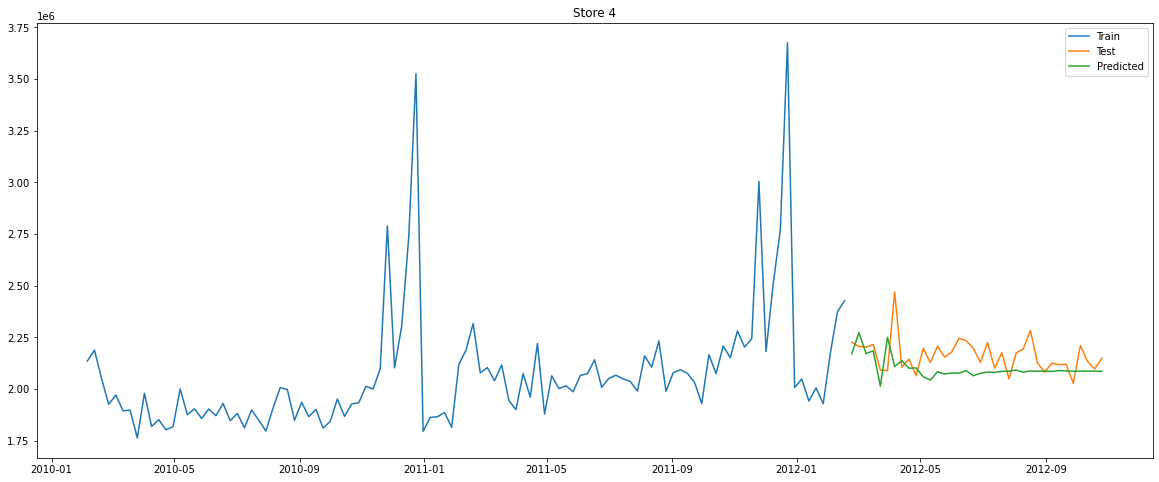

In [34]:
forecast(df_train4,df_test4,results4,'Store 4')

# Vector Auto Regressive Moving Average(VARMA)

## Auto ARIMA to check optimal P and Q

In [35]:
def auto_arima_check(df_train20,label):
    pq = []
    for name, column in df_train20[['Weekly_Sales','MarkDown2','MarkDown3']].iteritems():
        print(label)
        print(f'Searching order of p and q for : {name}')
        stepwise_model = auto_arima(df_train20[name],start_p=2, start_q=2,max_p=15, max_q=15, seasonal=False,
            trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
        parameter = stepwise_model.get_params().get('order')
        print(f'optimal order for:{name} is: {parameter} \n\n')
        pq.append(stepwise_model.get_params().get('order'))
    return pq

In [36]:
pq_store20 = auto_arima_check(df_train20,'Store 20')
pq_store4 = auto_arima_check(df_train20,'Store 4')

Store 20
Searching order of p and q for : Weekly_Sales
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3017.717, Time=0.16 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3424.524, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3036.372, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3357.588, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3014.138, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3338.516, Time=0.02 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3014.818, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3011.180, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3337.157, Time=0.02 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3007.134, Time=0.08 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=3006.465, Time=0.14 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(4,0,3)(0,0,0)[0]             : AIC=inf, Time=0.15 sec
 ARIMA(3,0,4)(0,0,0)[0]             : AIC=3008.148, Ti

In [37]:
pq_store20, pq_store4

([(3, 0, 3), (0, 1, 2), (0, 0, 1)], [(3, 0, 3), (0, 1, 2), (0, 0, 1)])

## VARMA

In [38]:
def varma_model(df_train20,  df_test20, pq, label):
    df_results_moni = pd.DataFrame(columns=['p', 'q','MAPE'])
    start = timer()
    for i in pq:
        if i[0]== 0 and i[2] ==0:
            pass
        else:
            print(f' Running for {i}')
            model = sm.tsa.VARMAX(df_train20, order=(i[0],i[2]),method_kwargs={"warn_convergence": False}).fit(disp=False)
            result = model.forecast(steps = len(df_test20))
            df_test20.reset_index(drop=True,inplace=True)
            result.reset_index(drop=True,inplace=True)
            mape = np.round((abs(result['Weekly_Sales'] - df_test20['Weekly_Sales'])/ df_test20['Weekly_Sales'] * 100).mean(), 1)
            df_results_moni = df_results_moni.append({'p': i[0], 'q': i[2], 'MAPE': mape }, ignore_index=True)

            #Plotting
            idx = pd.date_range(start='2012-02-24', end='2012-10-26', freq='7D')
            result['Date'] = idx
            df_test20['Date'] = idx
            df_train20['Date'] = df_train20.index

            plt.figure(figsize = (20,8))
            plt.plot(df_train20['Date'],df_train20['Weekly_Sales'],label = 'Train')
            plt.plot(df_test20['Date'],df_test20['Weekly_Sales'],label = 'Test')
            plt.plot(result['Date'],result['Weekly_Sales'],label = 'Predicted')
            plt.title(label+'  Order: p = '+ str(i[0]) + ' q = '+ str(i[2]) +'  MAPE: '+str(mape))
            plt.legend()
            plt.show()
            df_test20.drop('Date',axis=1,inplace=True)
            df_train20.drop('Date',axis=1,inplace=True)
            result.drop('Date',axis=1,inplace=True)

    end = timer()
    print(f' Total time taken in seconds: {(end - start)}')



## Store 20

In [39]:
pq_store20.append((6,0,6)) #checking for p=6, q=6 as well

 Running for (3, 0, 3)


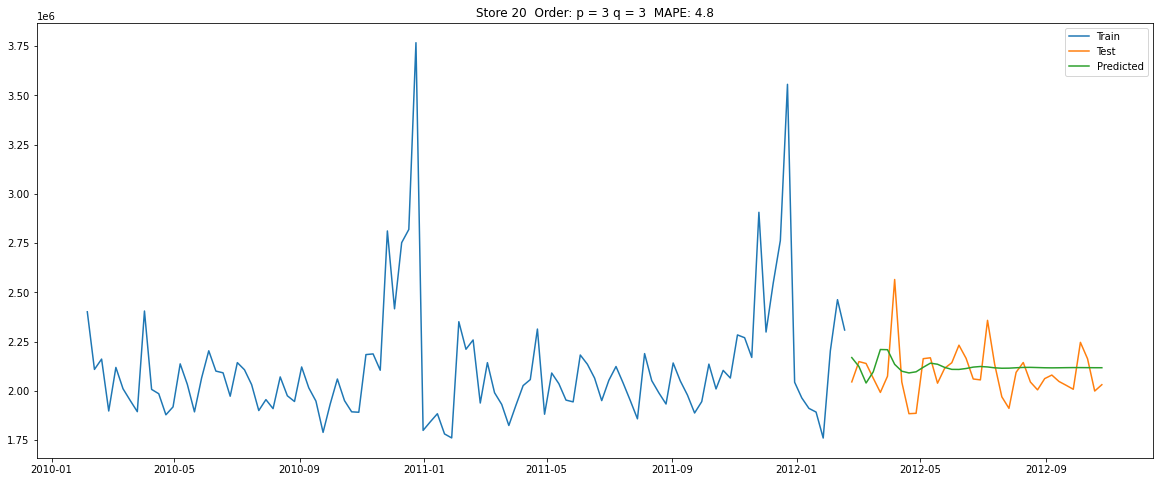

 Running for (0, 1, 2)


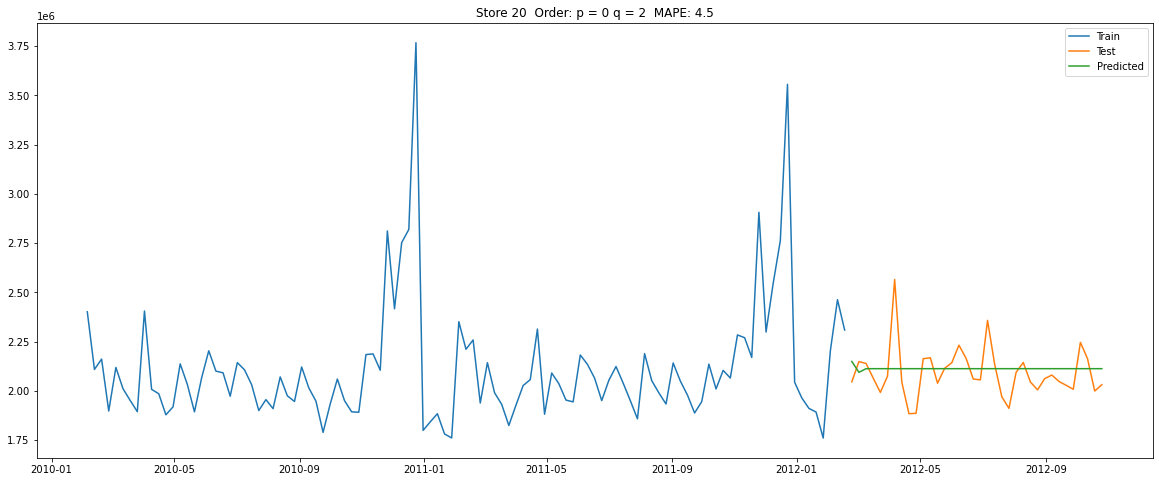

 Running for (0, 0, 1)


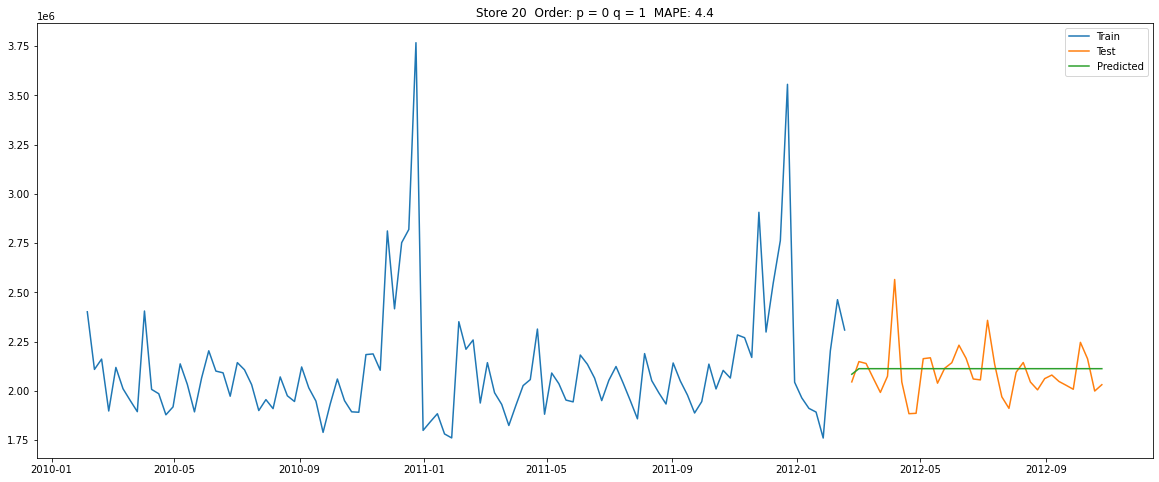

 Running for (6, 0, 6)


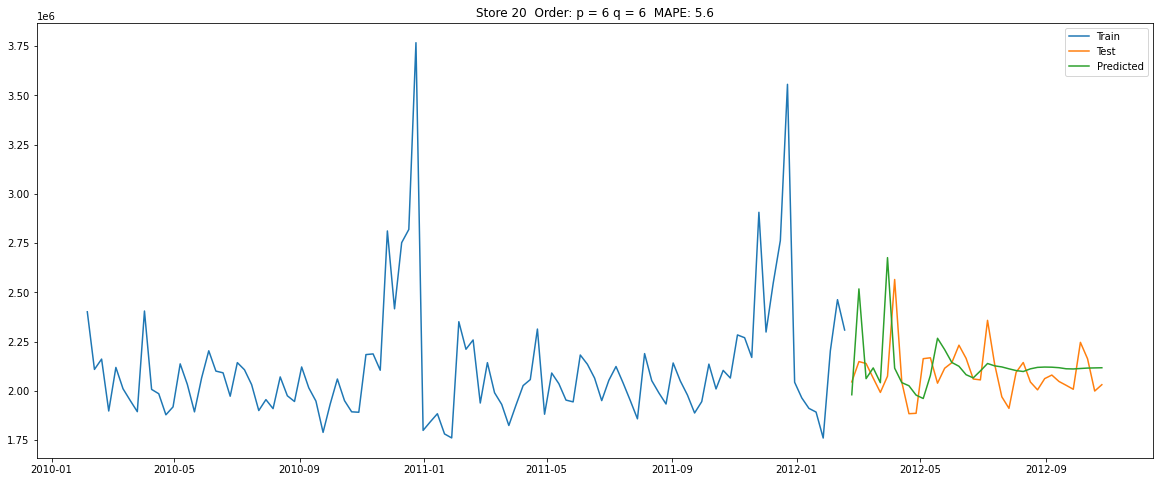

 Total time taken in seconds: 55.098557708


In [40]:
varma_model(df_train20,  df_test20,pq_store20, 'Store 20')

## Store 4

In [41]:
pq_store4.append((6,0,6)) #checking for p=6, q=6 as well

 Running for (3, 0, 3)


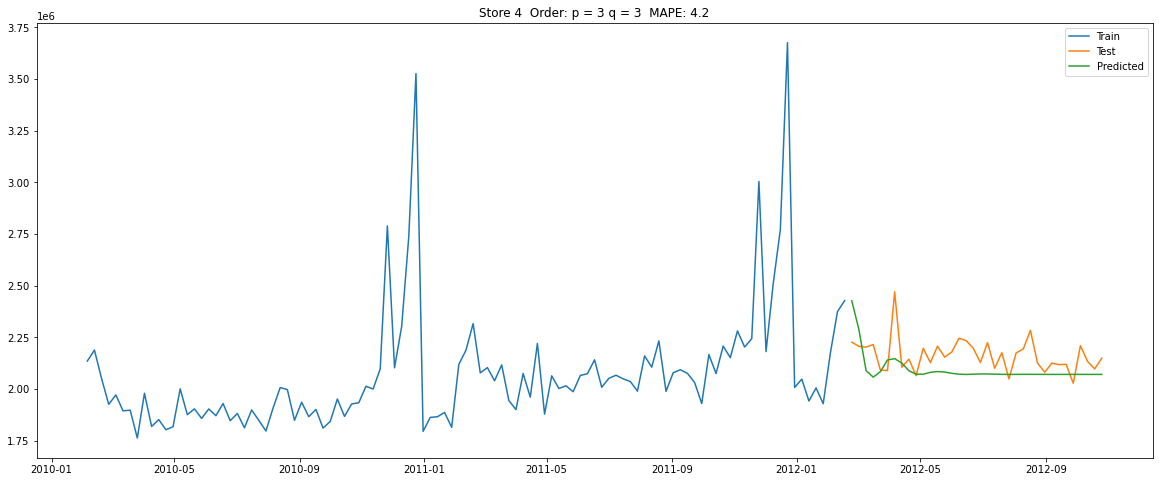

 Running for (0, 1, 2)


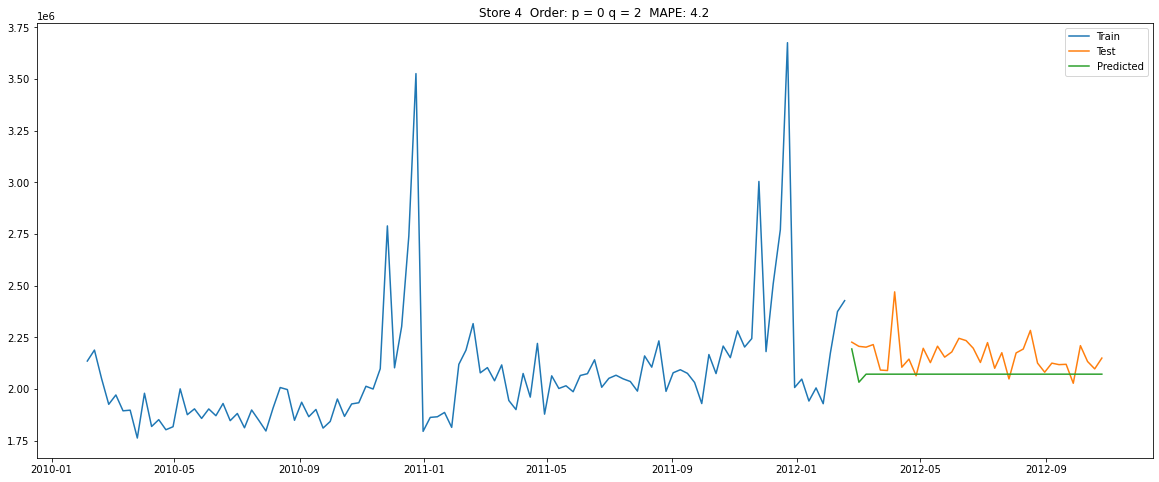

 Running for (0, 0, 1)


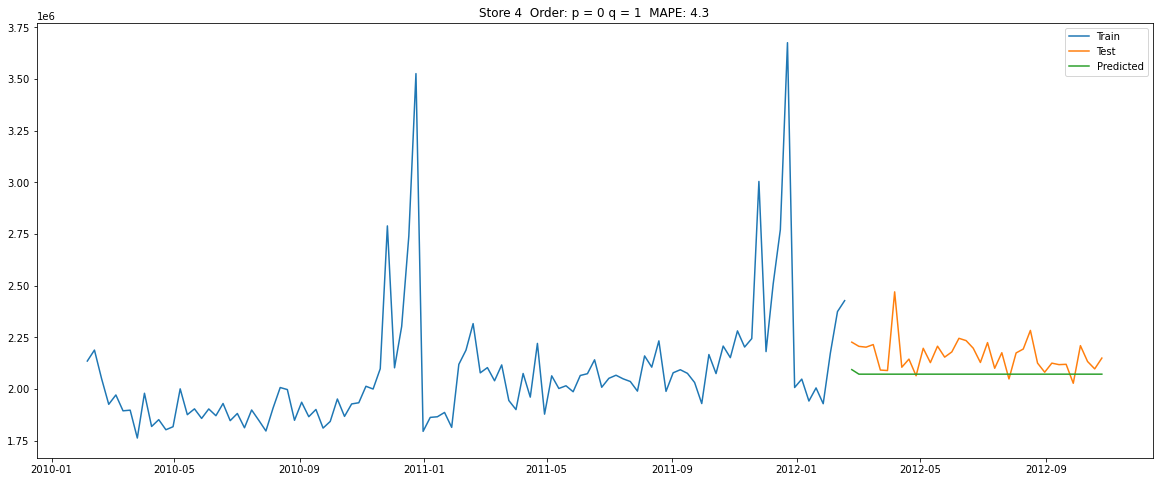

 Running for (6, 0, 6)


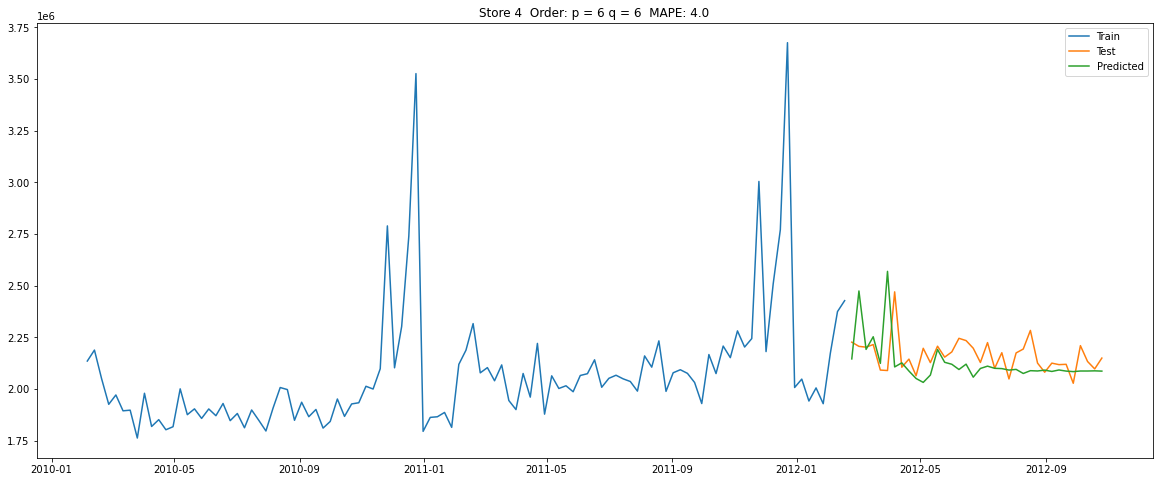

 Total time taken in seconds: 42.165196583


In [42]:
varma_model(df_train4,  df_test4,pq_store4, 'Store 4')